In [2]:
!pip install transformers wikipedia newspaper3k GoogleNews pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import wikipedia
from newspaper import Article, ArticleException
from GoogleNews import GoogleNews
import IPython
from pyvis.network import Network

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

In [5]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [6]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [7]:
def from_small_text_to_kb(text, verbose=False):
    kb = KB()

    # Tokenizer text
    model_inputs = tokenizer(text, max_length=512, padding=True, truncation=True,
                            return_tensors='pt')
    if verbose:
        print(f"Num tokens: {len(model_inputs['input_ids'][0])}")

    # Generate
    gen_kwargs = {
        "max_length": 216,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": 3
    }
    generated_tokens = model.generate(
        **model_inputs,
        **gen_kwargs,
    )
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    # create kb
    for sentence_pred in decoded_preds:
        relations = extract_relations_from_model_output(sentence_pred)
        for r in relations:
            kb.add_relation(r)

    return kb

In [9]:
def save_network_html(kb, filename="network.html"):
    # create network
    net = Network(directed=True, width="700px", height="700px", bgcolor="#eeeeee")

    # nodes
    color_entity = "#00FF00"
    for e in kb.entities:
        net.add_node(e, shape="circle", color=color_entity)

    # edges
    for r in kb.relations:
        net.add_edge(r["head"], r["tail"],
                    title=r["type"], label=r["type"])

    # save network
    net.repulsion(
        node_distance=200,
        central_gravity=0.2,
        spring_length=200,
        spring_strength=0.05,
        damping=0.09
    )
    net.set_edge_smooth('dynamic')
    net.show(filename)

In [18]:
text ="""
Shakira Isabel Mebarak Ripoll (/ʃəˈkɪərə/ shə-KEER-ə, Spanish: [(t)ʃaˈkiɾa]; born 2 February 1977)[3] is a Colombian singer and songwriter.[4] Born and raised in Barranquilla, she has been referred to as the "Queen of Latin Music"[5] and is noted for her musical versatility.[6] She made her recording debut with Sony Music Colombia at the age of 13. Following the commercial failure of her first two albums, Magia (1991) and Peligro (1993), she rose to prominence in Hispanic countries with her next albums, Pies Descalzos (1995) and Dónde Están los Ladrones? (1998). She entered the English-language market with her fifth album, Laundry Service (2001), which sold over 13 million copies worldwide. Buoyed by the international success of her singles "Whenever, Wherever" and "Underneath Your Clothes", the album propelled her reputation as a leading crossover artist. Broadcast Music, Inc., described Shakira as a "pioneer" who extended the global reach of Latino singers.[7]

Her success was further solidified with the Spanish albums Fijación Oral, Vol. 1 (2005), Sale el Sol (2010), and El Dorado (2017), all of which topped the Billboard Top Latin Albums chart and were certified diamond (Latin) by the Recording Industry Association of America. Meanwhile, her English albums Oral Fixation, Vol. 2 (2005), She Wolf (2009) and Shakira (2014) were all certified gold, platinum, or multi-platinum in various countries worldwide. Some of her songs have charted at number one in multiple countries, including "Whenever, Wherever", "La Tortura", "Hips Don't Lie", "Beautiful Liar", "Waka Waka (This Time for Africa)", "Loca", "Can't Remember to Forget You", "Chantaje", "Bzrp Music Sessions, Vol. 53", and "TQG". She served as a coach on two seasons of the American singing competition television series The Voice (2013–2014).

With a catalog of 145 songs, Shakira has sold over 95 million records, making her one of the best-selling music artists of all time.[8] Billboard reported that as of 2023, she is the best-selling female Latin artist of all time.[8] She is credited with opening the doors of the international market for other Latin artists.[9] She has received numerous awards, including three Grammy Awards, twelve Latin Grammy Awards, four MTV Video Music Awards, seven Billboard Music Awards, thirty-nine Billboard Latin Music Awards, twenty-one Guinness World Records, and a star on the Hollywood Walk of Fame. She was named the Top Female Latin Artist of the Decade by Billboard twice (2000s and 2010s).[10][11] For her philanthropic work with her Barefoot Foundation and her contributions to music she received the Latin Recording Academy Person of the Year and Harvard Foundation Artist of the Year awards in 2011. She was appointed to the President's Advisory Commission on Educational Excellence for Hispanics in the United States in 2011, and Chevalier of the Order of Arts and Letters by the French government in 2012
Shakira Isabel Mebarak Ripoll was born on 2 February 1977 in Barranquilla, Colombia. She is the only child of William Mebarak Chadid and Nidia Ripoll Torrado. She is of Spanish and Lebanese descent.[12][13] Her father William was born in New York City to a family from Lebanon. When he was five, his family moved to Colombia.[14] Her mother's side has two Spanish surnames, Ripoll and Torrado, the former of which is Catalan and originates from four brothers who immigrated from Catalonia to coastal Colombia in the 19th century.[15] She has also stated that she has distant Italian roots through an ancestor with the surname "Pisciotti".[16] She was raised Catholic and attended Catholic schools.[17] She has eight older half-siblings from her father's previous marriage.[18] Shakira spent much of her youth in Barranquilla, a city located on the northern Caribbean coast of Colombia.

Shakira wrote her first poem, titled "La rosa de cristal" ('The Crystal Rose'), when she was only four years old.[19] As she was growing up, she was fascinated watching her father writing stories on a typewriter,[19] and asked for one as a Christmas gift. She got that typewriter at age seven,[19] and has continued writing poetry since then. These poems eventually evolved into songs. When Shakira was two years old, an older half-brother was killed in a motorcycle accident; six years later, at age eight, Shakira wrote her first song, titled "Tus gafas oscuras" ('Your dark glasses'), which was inspired by her father, who for years wore dark glasses to hide his grief.[20]

When Shakira was four, her father took her to a local Middle Eastern restaurant, where Shakira first heard the doumbek, a traditional drum used in Middle-Eastern music and which typically accompanied belly dancing.[21] She started dancing on the table, and the experience made her realize that she wanted to be a performer. She enjoyed singing for schoolmates and teachers (and even the nuns) at her Catholic school, but in second grade, she was rejected for the school choir because her vibrato was too strong. The music teacher told her that she sounded "like a goat".[21][22] At school, she was often sent out of the class because of her hyperactivity.[23] She says she had also been known as "the belly dancer girl", as she would demonstrate every Friday at school a number she had learned.[21] "That's how I discovered my passion for live performance," she says.[24][18] To instill gratitude in Shakira for her upbringing, her father took her to a local park to see orphans who lived there. The images stayed with her, and she said to herself: "One day I'm going to help these kids when I become a famous artist."[18]

Between ages ten and thirteen, Shakira was invited to various events in Barranquilla and gained some recognition in the area.[25] It was at this approximate time that she met local theater producer Monica Ariza, who was impressed with her and as a result tried to help her career. During a flight from Barranquilla to Bogotá, Ariza convinced Sony Colombia executive Ciro Vargas to hold an audition for Shakira in a hotel lobby. Vargas held Shakira in high regard and, returning to the Sony office, gave the cassette to a song and artist director. However, the director was not overly excited and thought Shakira was something of "a lost cause". Undaunted and still convinced that Shakira had talent, Vargas set up an audition in Bogotá. He arranged for Sony Colombia executives to arrive at the audition, with the idea of surprising them with Shakira's performance. She performed three songs for the executives and impressed them enough for her to be signed to record three albums.[26]

"""
kb = from_small_text_to_kb(text, verbose=True)
kb.print()


Num tokens: 512
Relations:
  {'head': 'Whenever, Wherever', 'type': 'followed by', 'tail': 'Underneath Your Clothes'}
  {'head': 'Shakira', 'type': 'date of birth', 'tail': '2 February 1977'}
  {'head': 'Shakira', 'type': 'place of birth', 'tail': 'Barranquilla'}
  {'head': 'Whenever, Wherever', 'type': 'performer', 'tail': 'Shakira'}
  {'head': 'Pies Descalzos', 'type': 'performer', 'tail': 'Shakira'}
  {'head': 'Laundry Service', 'type': 'performer', 'tail': 'Shakira'}


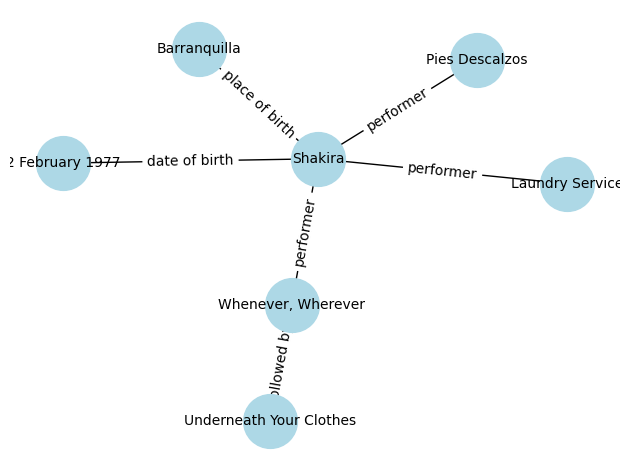

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
graph = nx.Graph()
kb_relations=kb.relations



# Iterate over the list of triples
for triple in kb_relations:
    # Extract the subject, predicate (type), and object
    subject = triple['head']
    predicate = triple['type']
    object_ = triple['tail']

    # Add edges to the graph
    graph.add_edge(subject, object_, predicate=predicate)

# Draw the graph
pos = nx.spring_layout(graph)
labels = nx.get_edge_attributes(graph, 'predicate')
nx.draw_networkx(graph, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=10)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

# Display the graph
plt.axis('off')
plt.tight_layout()

plt.show()